In [15]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc, norm
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples
matplotlib.rc('font', size=14,family='serif')
matplotlib.rc('legend', fontsize=14)

In [16]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 2
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = 0.46
scale = 0.1
d =  norm(loc= f_mean,scale=scale)

f = lambda x: d.logpdf(x) #mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=True)
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

(2, 1) (2, 1)
Testing lightweight implementation


sample: 100%|██████████| 512/512 [00:01<00:00, 495.58it/s, 7 steps of size 5.02e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.18s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     10.77     17.36      5.08      1.50     29.66     29.74      0.96
        kernel_length[0]      0.85      0.52      0.81      0.12      1.63     22.57      1.00
            kernel_tausq      0.56      0.57      0.39      0.12      1.23     36.61      0.94
              kernel_var     11.67      7.38     11.25      1.84     21.52     32.99      1.23

Number of divergences: 0


In [17]:
### plotting functions

def plot_gp(test_x,ax):
    mu, var = gp.posterior(test_x,single=True)
    std = jnp.sqrt(var)
    ax.plot(test_x,test_y,label='True',color='k')
    ax.scatter(train_x,train_y,color='k')
    ax.plot(test_x,mu,label='GP')
    ax.fill_between(test_x[:,0],mu-1.96*std,mu+1.96*std,alpha=0.4)
    ax.set(xlabel=r'$x$',ylabel=r'$f(x)$')
    ax.legend()

def plot_hyperparams(gp,fig,ax):
    colors = matplotlib.colormaps['YlGn']
    l = np.array(gp.samples["kernel_length"].squeeze(-1))
    o = np.array(gp.samples["kernel_var"])
    lp = -np.array(gp.samples["minus_log_prob"])
    lp_min, lp_max = np.min(lp), np.max(lp)
    cols = np.linspace(lp_min,lp_max,len(lp))
    cols = (cols - lp_min)/(lp_max - lp_min)
    ax.scatter(l,o)
    sc = ax.scatter(l,o,c = lp, vmin = lp_min, vmax=lp_max,cmap= colors)
    fig.colorbar(sc,ax=ax)
    ax.set(xlabel=r'lengthscale',ylabel=r'outputscale')

def plot_acq(acq_x,acq_vals,next_x,next_val,mc_points,gp,ax):
    ax.plot(acq_x,acq_vals)
    ax.scatter(next_x,next_val,color='r',label=r'next point')
    ax.set(xlabel=r'$x$',ylabel=r'$\mathrm{IPV}(x)$')
    _, pre_var = gp.posterior(mc_points,unstandardize=False)
    pre_var = pre_var.mean()
    for pt in gp.train_x:
        ax.axvline(pt,color='k',ls='-.',lw=0.5)
        ax.axhline(pre_var,color='k',lw=1)
    ax.legend()

INFO:[NS]: Nested Sampling took 1.75s
INFO:[NS]: jaxns did 1440 likelihood evaluations


LogZ info logz_mean: = 0.0186, dlogz: = 0.2576, 


INFO:[AQ]: Acquisition optimization took 0.88 s


Next point at x = [0.09710105] with acquisition function value = 0.026895401384380194


sample: 100%|██████████| 384/384 [00:00<00:00, 536.52it/s, 7 steps of size 3.91e-01. acc. prob=0.81]
INFO:[GP]: MCMC elapsed time: 0.83s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 1.64s
INFO:[NS]: jaxns did 2625 likelihood evaluations


LogZ info logz_mean: = -1.1929, dlogz: = 0.2775, 


INFO:[AQ]: Acquisition optimization took 1.11 s


Next point at x = [0.34420902] with acquisition function value = 0.4649670790069226


sample: 100%|██████████| 384/384 [00:00<00:00, 582.42it/s, 7 steps of size 5.40e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 0.75s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.16s
INFO:[NS]: jaxns did 2364 likelihood evaluations


LogZ info logz_mean: = -0.5477, dlogz: = 0.2824, 


INFO:[AQ]: Acquisition optimization took 0.89 s


Next point at x = [0.52891946] with acquisition function value = 0.0017826062541244185


sample: 100%|██████████| 384/384 [00:00<00:00, 576.57it/s, 7 steps of size 5.15e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 0.75s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 1.77s
INFO:[NS]: jaxns did 2664 likelihood evaluations


LogZ info logz_mean: = -0.0789, dlogz: = 0.2743, 


INFO:[AQ]: Acquisition optimization took 0.84 s


Next point at x = [0.43171987] with acquisition function value = 0.00019768396126259094


sample: 100%|██████████| 384/384 [00:00<00:00, 564.76it/s, 7 steps of size 7.73e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 0.77s


----------------------Step 4 complete----------------------

BO took 15.61 s 


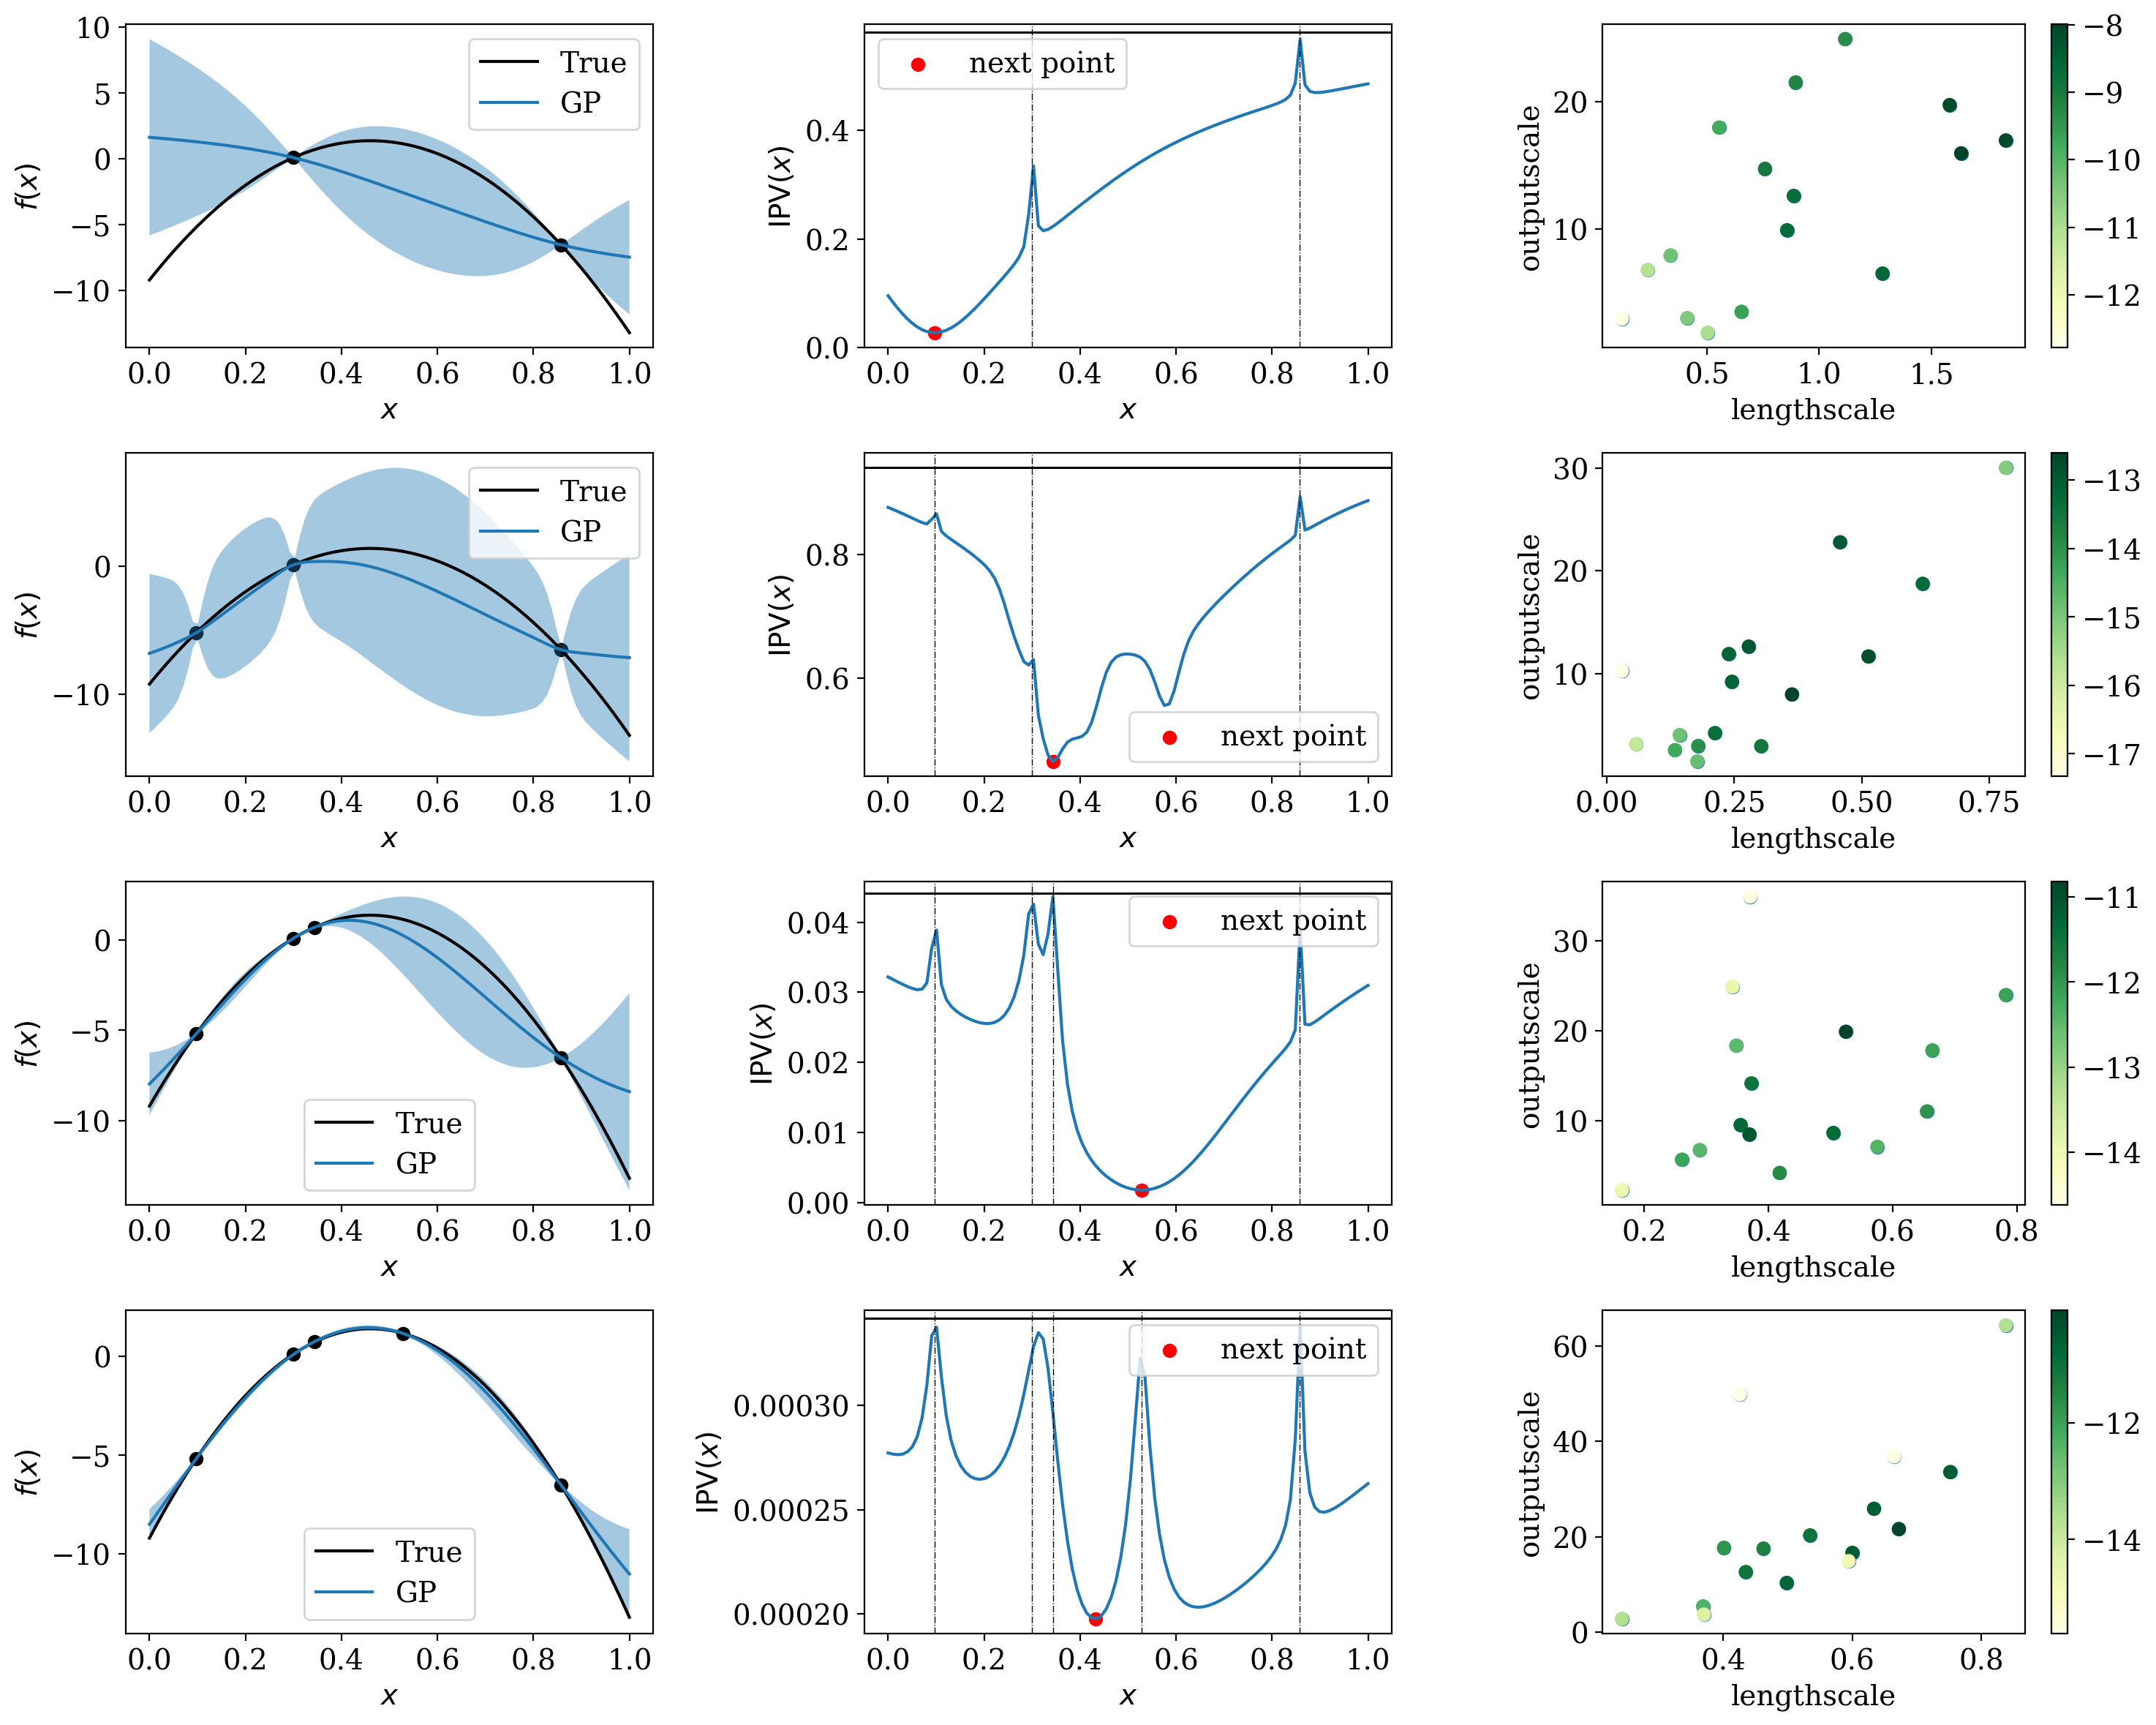

In [18]:
nsteps = 4 # 32
mc_points_size = 8

fig, ax = plt.subplots(nsteps,3,figsize=(15,3*nsteps))
start = time.time()
for i in range(nsteps):
    plot_gp(test_x,ax[i,0])
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    plot_hyperparams(gp,fig,ax[i,2])
    print(f"LogZ info "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    mc_points = samples[:mc_points_size,:]
    acq_func = IPV(gp,mc_points) #   EI(gp,gp.train_y.max()) 
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform()
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    acq_vals = vmap(acq_func)(test_x)
    # print(acq_vals.shape)
    plot_acq(test_x,acq_vals,next_x,results.fun,mc_points=mc_points,gp=gp,ax=ax[i,1])
    gp = saas_fbgp(train_x,train_y,noise=1e-4)
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.fit(rng_key,warmup_steps=256,num_samples=128,thinning=8,verbose=False)

    print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")
fig.tight_layout()

In [19]:
print(gp.samples["kernel_length"].shape)

(16, 1)


In [20]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.0001,num_samples_equal=1000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 2.18s
INFO:[NS]: jaxns did 142631 likelihood evaluations


LogZ info: logz_mean: = 0.0640, dlogz: = 0.1487, 


Removed no burn in
Removed no burn in


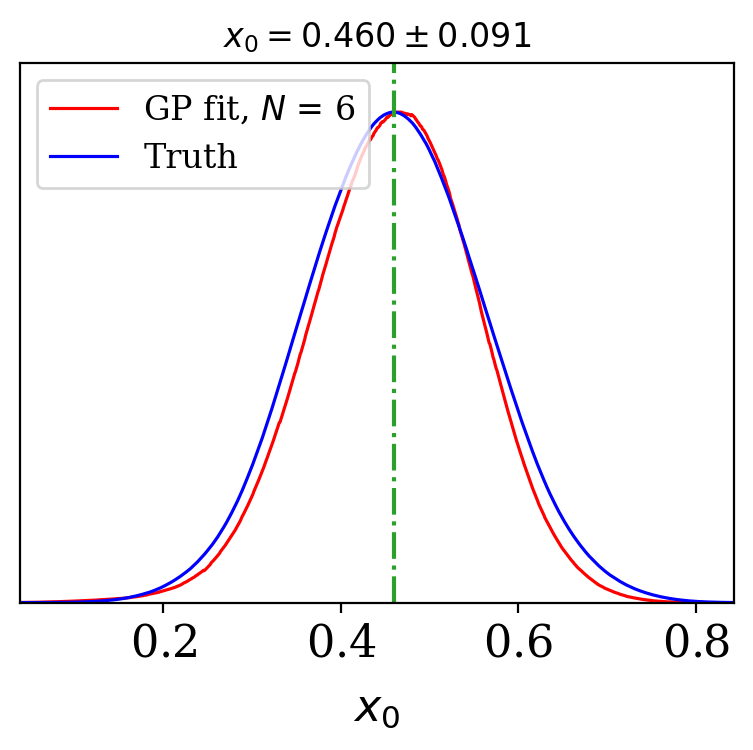

In [21]:
test_samples = np.random.normal(loc=f_mean,scale=scale,size=int(1e4))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=4,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 16
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 12
g.settings.title_limit_fontsize = 12
g.plot_1d([gp_samples,true_samples],'x_0',filled=[True,False],colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','Truth'],
                                contour_lws=[1,1.5],title_limit=1) # type: ignore
g.add_legend([f'GP fit, $N$ = {gp.train_y.shape[0]}','Truth'],legend_loc='upper left')
for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean, color='C2', ls='-.')


In [22]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 2
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = 0.46
scale = 0.1
d =  norm(loc= f_mean,scale=scale)

f = lambda x: d.logpdf(x) #mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

(2, 1) (2, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1365.05it/s, 7 steps of size 6.37e-01. acc. prob=0.86]
INFO:[GP]: MCMC elapsed time: 0.86s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     51.75    171.73      5.32      0.68     33.96     35.90      1.01
        kernel_length[0]      0.77      0.46      0.71      0.18      1.46     43.38      0.99
            kernel_tausq      0.57      0.68      0.37      0.04      1.41     34.81      0.97
              kernel_var     13.71      9.92     10.63      2.98     23.94     21.51      1.13

Number of divergences: 0


INFO:[NS]: Nested Sampling took 1.93s
INFO:[NS]: jaxns did 1440 likelihood evaluations


LogZ info logz_mean: = 2.7466, dlogz: = 0.2585, 


INFO:[AQ]: Acquisition optimization took 0.75 s


Next point at x = [0.] with acquisition function value = -1.2354097106105455


sample: 100%|██████████| 384/384 [00:00<00:00, 535.22it/s, 7 steps of size 3.46e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 0.83s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 1.76s
INFO:[NS]: jaxns did 2419 likelihood evaluations


LogZ info logz_mean: = -0.6038, dlogz: = 0.2961, 


INFO:[AQ]: Acquisition optimization took 2.65 s


Next point at x = [0.5233495] with acquisition function value = -0.3160497947660797


sample: 100%|██████████| 384/384 [00:00<00:00, 574.55it/s, 7 steps of size 5.62e-01. acc. prob=0.84]
INFO:[GP]: MCMC elapsed time: 0.78s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 1.90s
INFO:[NS]: jaxns did 2491 likelihood evaluations


LogZ info logz_mean: = -0.3666, dlogz: = 0.2881, 


INFO:[AQ]: Acquisition optimization took 1.16 s


Next point at x = [0.30084514] with acquisition function value = -2.4486789344327225e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 507.20it/s, 3 steps of size 6.89e-01. acc. prob=0.86]
INFO:[GP]: MCMC elapsed time: 0.87s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 1.87s
INFO:[NS]: jaxns did 2734 likelihood evaluations


LogZ info logz_mean: = -0.0951, dlogz: = 0.2732, 


INFO:[AQ]: Acquisition optimization took 0.41 s


Next point at x = [0.49531004] with acquisition function value = -3.390711003936375e-20


sample: 100%|██████████| 384/384 [00:00<00:00, 587.86it/s, 3 steps of size 6.84e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 0.75s


----------------------Step 4 complete----------------------

BO took 17.16 s 


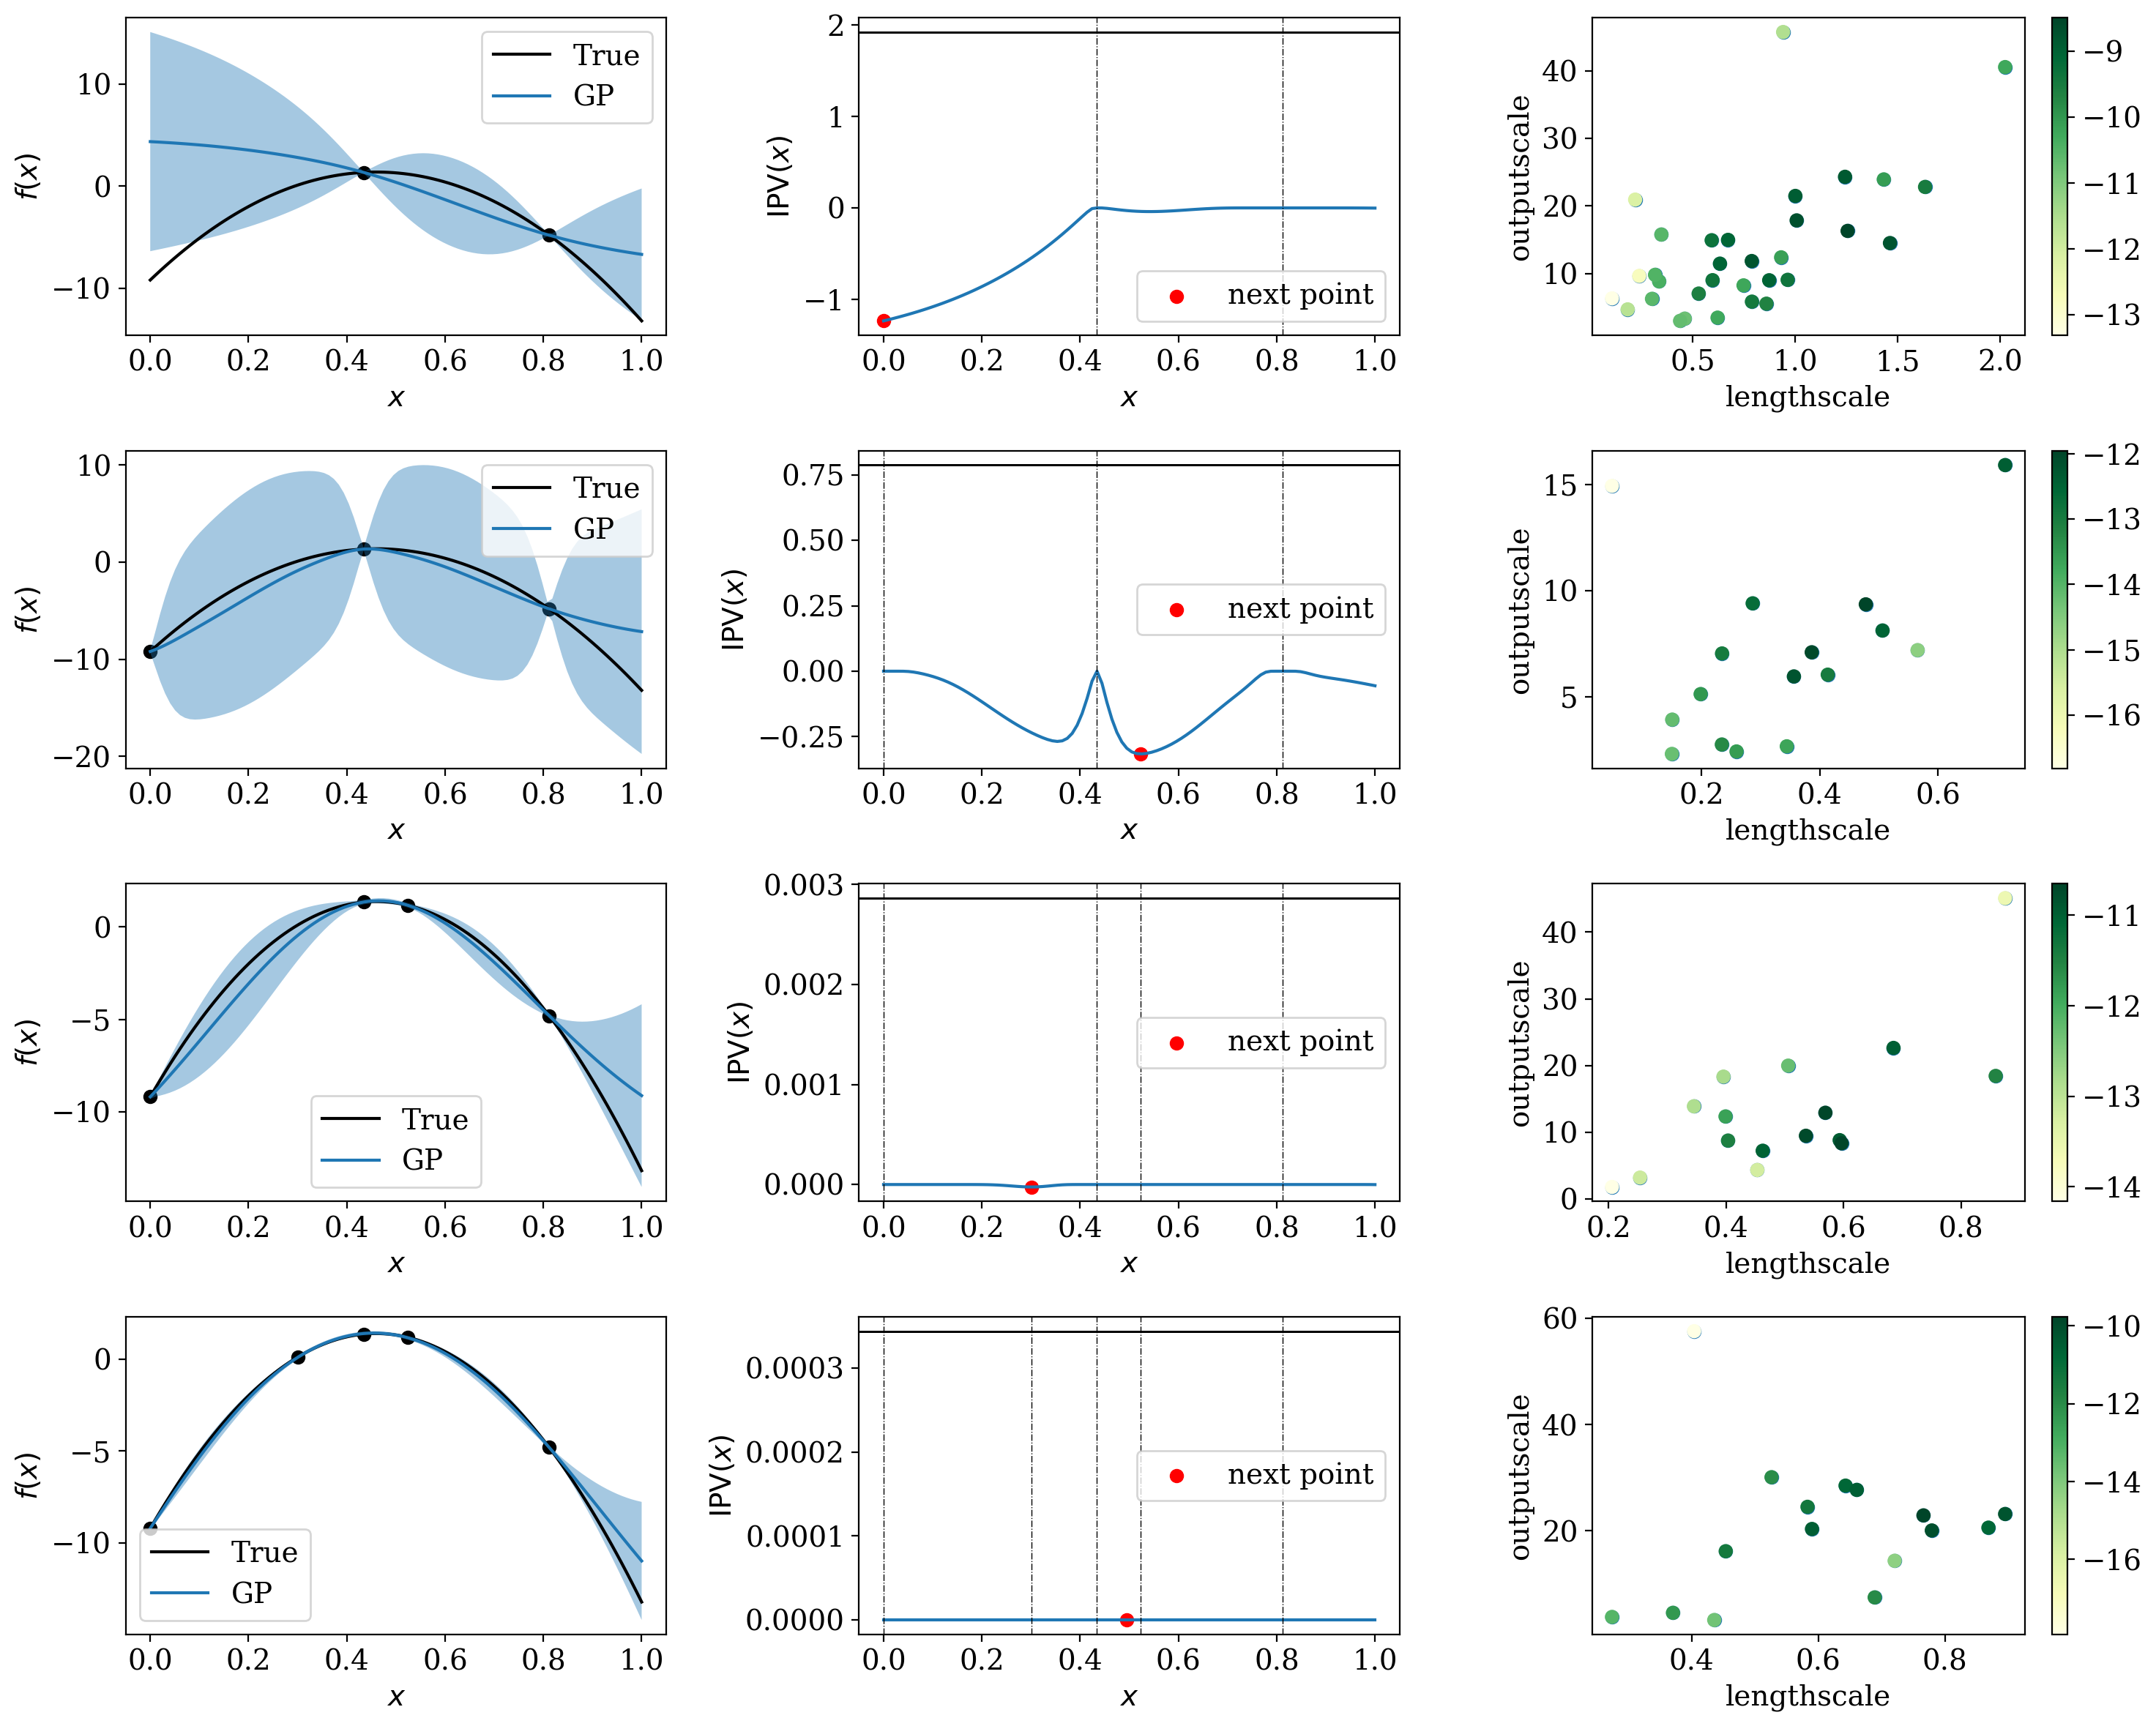

In [23]:
nsteps = 4 # 32
mc_points_size = 8

fig, ax = plt.subplots(nsteps,3,figsize=(15,3*nsteps))
start = time.time()
for i in range(nsteps):
    plot_gp(test_x,ax[i,0])
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    plot_hyperparams(gp,fig,ax[i,2])
    print(f"LogZ info "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    mc_points = samples[:mc_points_size,:]
    acq_func = EI(gp,gp.train_y.max()) 
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform()
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    acq_vals = vmap(acq_func)(test_x)
    # print(acq_vals.shape)
    plot_acq(test_x,acq_vals,next_x,results.fun,mc_points=mc_points,gp=gp,ax=ax[i,1])
    gp = saas_fbgp(train_x,train_y,noise=1e-4)
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.fit(rng_key,warmup_steps=256,num_samples=128,thinning=8,verbose=False)

    print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")
fig.tight_layout()

In [24]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.0001,num_samples_equal=1000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 2.44s
INFO:[NS]: jaxns did 140243 likelihood evaluations


LogZ info: logz_mean: = 0.0636, dlogz: = 0.1487, 


Removed no burn in
Removed no burn in


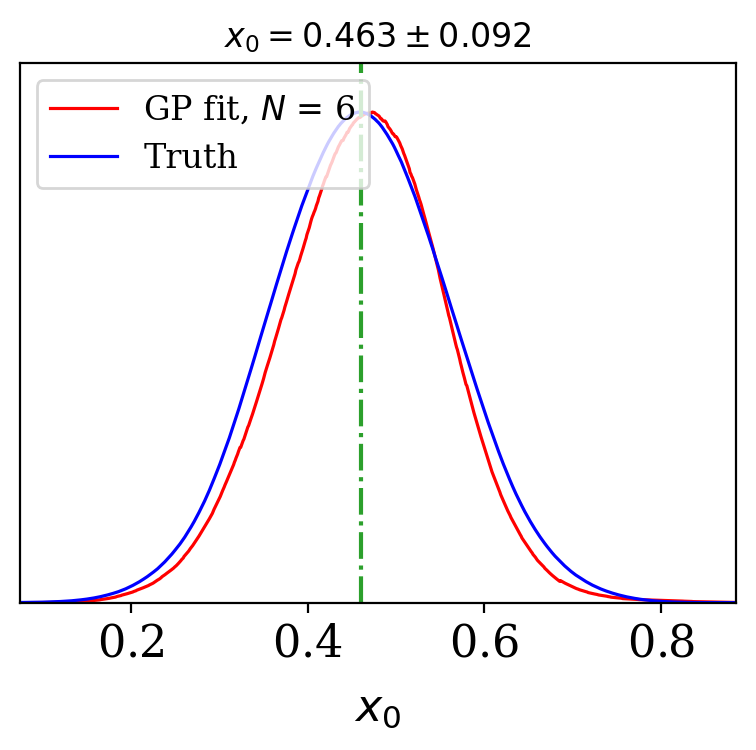

In [25]:
test_samples = np.random.normal(loc=f_mean,scale=scale,size=int(1e4))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=4,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 16
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 12
g.settings.title_limit_fontsize = 12
g.plot_1d([gp_samples,true_samples],'x_0',filled=[True,False],colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','Truth'],
                                contour_lws=[1,1.5],title_limit=1) # type: ignore
g.add_legend([f'GP fit, $N$ = {gp.train_y.shape[0]}','Truth'],legend_loc='upper left')
for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean, color='C2', ls='-.')
